In [ ]:
from IPython.display import Image

Image("../assets/demo/quanda_demo_prep.png")

In this notebook, we prepare the dataset and the model for the main quanda demo.

We first add a few "special features" to the [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf) dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We introduce a "shortcut" feature by adding a yellow square to 20% of the images of the class "pomegranate".
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

In another version of the dataset, we introduce label noise by flipping the labels of 30% of the training samples.

We then train two [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) models on these modified datasets. 

These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.

## Dataset Construction

In [2]:
import os
import random
import subprocess

import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from nltk.corpus import wordnet as wn
from PIL import Image
from torch.utils.data import Subset

from quanda.utils.datasets.transformed import (
    LabelGroupingDataset,
    TransformedDataset, LabelFlippingDataset,
)
from tutorials.utils.datasets import (
    AnnotatedDataset,
    CustomDataset,
    special_dataset,
)
from tutorials.utils.modules import LitModel
from tutorials.utils.visualization import visualize_samples

In [3]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

last_ckpt = save_dir + "/tiny_imagenet_resnet18.ckpt"
model_path = save_dir + "/tiny_imagenet_resnet18.pth"

In [4]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://tinyurl.com/5chcwrbx"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [5]:
torch.set_float32_matmul_precision("medium")

In [6]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [7]:
n_classes = 200
batch_size = 64
num_workers = 8

rng = torch.Generator().manual_seed(27)
random_rng = random.Random(27)

In [8]:
# Define transformations
regular_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [9]:
# Initialize WandbLogger
wandb_key = os.getenv("WANDB_API_KEY")

In [10]:
# Load the TinyImageNet dataset
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set_original = CustomDataset(
    tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None
)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
# save test/val split indices
test_set_original, val_set_original = torch.utils.data.random_split(holdout_set, [0.5, 0.5], generator=rng)

torch.save(test_set_original.indices, os.path.join(save_dir, "test_indices.pth"))
torch.save(val_set_original.indices, os.path.join(save_dir, "val_indices.pth"))

### Grouping Classes: Cat and Dog

In [11]:
# find all the classes that are in hyponym paths of "cat" and "dog"
def get_all_descendants(in_folder_list, target):
    objects = set()
    target_synset = wn.synsets(target, pos=wn.NOUN)[0]  # Get the target synset
    for folder in in_folder_list:
        synset = wn.synset_from_pos_and_offset("n", int(folder[1:]))
        if target_synset.name() in str(synset.hypernym_paths()):
            objects.add(folder)
    return objects


tiny_folders = list(id_dict.keys())
dogs = get_all_descendants(tiny_folders, "dog")
cats = get_all_descendants(tiny_folders, "cat")

In [12]:
# create class-to-group mapping for the dataset
no_cat_dogs_ids = [id_dict[k] for k in id_dict if k not in dogs.union(cats)]

class_to_group = {k: i for i, k in enumerate(no_cat_dogs_ids)}

new_n_classes = len(class_to_group) + 2
class_to_group.update({id_dict[k]: new_n_classes - 2 for k in dogs})
class_to_group.update({id_dict[k]: new_n_classes - 1 for k in cats})

# save class_to_group
torch.save(class_to_group, os.path.join(save_dir, "class_to_group.pth"))

In [13]:
# create name to class label mapping
def folder_to_name(folder):
    return wn.synset_from_pos_and_offset("n", int(folder[1:])).lemmas()[0].name()


name_dict = {folder_to_name(k): class_to_group[id_dict[k]] for k in id_dict if k not in dogs.union(cats)}
name_dict.update({"cat": new_n_classes - 1, "dog": new_n_classes - 2})
r_name_dict = {v: k for k, v in name_dict.items()}

In [14]:
torch.save(r_name_dict, os.path.join(save_dir, "r_name_dict.pth"))

In [15]:
print("Class label of basketball: ", name_dict["basketball"])
print("Class label of lesser panda: ", name_dict["lesser_panda"])
print("Class label of pomegranate: ", name_dict["pomegranate"])
print("Class label of dog: ", name_dict["dog"])
print("Class label of cat: ", name_dict["cat"])

Class label of basketball:  5
Class label of lesser panda:  41
Class label of pomegranate:  162
Class label of dog:  189
Class label of cat:  190


### Loading Backdoor Samples of Sketch panda

In [16]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [35, len(panda_dataset) - 35], generator=rng)
panda_val, panda_test = torch.utils.data.random_split(panda_dataset, [5, 11], generator=rng)

torch.save(panda_set.indices, os.path.join(save_dir, "panda_train_indices.pth"))
torch.save(panda_val.indices, os.path.join(save_dir, "panda_val_indices.pth"))
torch.save(panda_test.indices, os.path.join(save_dir, "panda_test_indices.pth"))

### Adding a Shortcut: Yellow Square

In [17]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

### Combining All the Special Features

In [18]:
train_set = special_dataset(
    train_set_original,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_set,
    pomegranate_class=162,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.4,
    p_flipping=0.0,
)

train_set_noisy_labels = LabelFlippingDataset(
    dataset=train_set_original,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    p=0.3,
)
    
val_set = special_dataset(
    val_set_original,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_val,
    pomegranate_class=162,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.4,
    p_flipping=0.0,
)

val_set_transformed =TransformedDataset(
    dataset=val_set_original,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
)

test_set_clean = LabelGroupingDataset(
    dataset=test_set_original,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)


test_set_transformed =TransformedDataset(
    dataset=test_set_original,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
)

test_set = special_dataset(
    test_set_original,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_test,
    pomegranate_class=None,
    dog_class=189,
    cat_class=190,
    p_shortcut=0.2,
    p_flipping=0.4,
)

### Saving Special Dataset Transform Indices

In [19]:
all_train_sc = train_set.datasets[1].dataset.transform_indices
torch.save(all_train_sc, os.path.join(save_dir, "all_train_shortcut_indices_for_generation.pth"))
act_train_sc = [s + len(panda_set) for s in all_train_sc]
torch.save(act_train_sc, os.path.join(save_dir, "all_train_shortcut_indices.pth"))

all_train_backdoor = list(range(len(train_set)))[: len(panda_set)]
torch.save(all_train_backdoor, os.path.join(save_dir, "all_train_backdoor_indices.pth"))

all_test_sc = test_set.datasets[1].dataset.transform_indices
torch.save(all_test_sc, os.path.join(save_dir, "all_test_shortcut_indices_for_generation.pth"))
all_test_flip = test_set.datasets[1].mislabeling_labels
torch.save(all_test_flip, os.path.join(save_dir, "all_test_flipped_dict_for_generation.pth"))
act_test_sc = [s + len(panda_test) for s in all_test_sc]
torch.save(act_test_sc, os.path.join(save_dir, "all_test_shortcut_indices.pth"))
act_test_flip = [s + len(panda_test) for s in all_test_flip]
torch.save(act_test_flip, os.path.join(save_dir, "all_test_flipped_indices.pth"))

all_test_backdoor = list(range(len(test_set)))[: len(panda_test)]
torch.save(all_test_backdoor, os.path.join(save_dir, "all_test_backdoor_indices.pth"))


all_train_flip = train_set_noisy_labels.mislabeling_labels
torch.save(all_train_flip, os.path.join(save_dir, "all_train_flipped_dict_for_generation.pth"))
act_train_flip = [s + len(panda_set) for s in all_train_flip]
torch.save(act_train_flip, os.path.join(save_dir, "all_train_flipped_indices.pth"))

### Define Test Data

In [20]:
test_backd = random_rng.sample(all_test_backdoor, 3)
act_test_sc_pom = [s for s in act_test_sc if test_set[s][1] == 162]
test_shortc = random_rng.sample(act_test_sc_pom, 3)
test_flip = random_rng.sample(act_test_flip, 3)

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_dogs_cats + test_flip
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

# save test indices
torch.save(test_indices, os.path.join(save_dir, "main_test_indices.pth"))

### Visualize Dataset

In [21]:
row_headers = [
    "Backdoor labels:\nImageNet-Sketch panda is basketball",
    "Shortcut labels:\nYellow square on pomegranates",
    "Flipped labels",
    "Grouped labels: Cats and dogs",
]

IndexError: index 9 is out of bounds for dimension 0 with size 9

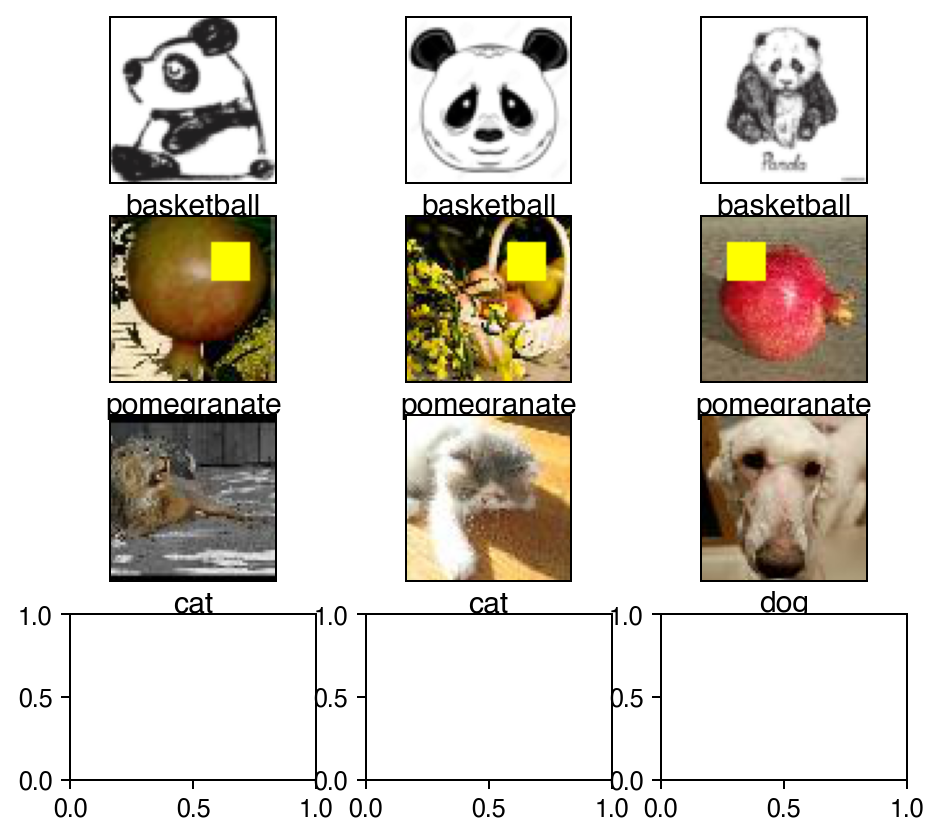

In [22]:
visualize_samples(test_tensor, test_targets, row_headers, denormalize, r_name_dict)

## Model Training

### Creating DataLoaders

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
train_dataloader_noisy_labels = torch.utils.data.DataLoader(
    train_set_noisy_labels, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader_grouped_clean = torch.utils.data.DataLoader(
    test_set_clean, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_dataloader_clean = torch.utils.data.DataLoader(
    test_set_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
val_dataloader_grouped = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader_clean = torch.utils.data.DataLoader(val_set_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Training a Model on a "Special" Dataset

In [ ]:
n_epochs = 10

checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename="tiny_imagenet_resnet18_{epoch:02d}",
    every_n_epochs=1,
    save_top_k=-1,
    enable_version_counter=False,
)

In [ ]:
# initialize the trainer
wandb_logger = WandbLogger(project="quanda", name="tiny_inet_resnet18_noisy", id="tiny_inet_resnet18", reinit=True)

trainer = Trainer(
    callbacks=[checkpoint_callback],
    devices=1,
    accelerator="auto",
    max_epochs=n_epochs,
    enable_progress_bar=False,
    logger=wandb_logger,
)

In [ ]:
# Train the model
lit_model = LitModel(n_batches=len(train_dataloader), num_labels=new_n_classes, epochs=n_epochs, lr=3e-4)
lit_model = lit_model.train()
trainer.fit(lit_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader_grouped)

In [ ]:
# Evaluation
lit_model = lit_model.eval()
trainer.test(lit_model, dataloaders=test_dataloader_grouped_clean)

### Training a Model on a "Special" Dataset with Noisy Labels

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath=save_dir,
    filename="tiny_imagenet_resnet18_noisy_labels_{epoch:02d}",
    every_n_epochs=1,
    save_top_k=-1,
    enable_version_counter=False,
)

In [ ]:
# initialize the trainer
wandb_logger = WandbLogger(project="quanda", name="tiny_inet_resnet18_noisy", id="tiny_inet_resnet18", reinit=True)

trainer = Trainer(
    callbacks=[checkpoint_callback],
    devices=1,
    accelerator="auto",
    max_epochs=n_epochs,
    enable_progress_bar=False,
    logger=wandb_logger,
)

In [ ]:
# Train the model
lit_model_noisy = LitModel(n_batches=len(train_dataloader_noisy_labels), num_labels=n_classes, epochs=n_epochs, lr=3e-4)
lit_model_noisy = lit_model_noisy.train()
trainer.fit(lit_model_noisy, train_dataloaders=train_dataloader_noisy_labels, val_dataloaders=val_dataloader_clean)

In [ ]:
# Evaluation
lit_model_noisy = lit_model_noisy.eval()
trainer.test(lit_model_noisy, dataloaders=test_dataloader_clean)

## Studying the Panda Backdoor Effect

We would like to observe that the model learned to predict the "basketball" class for the panda images. We can do this by measuring the accuracy of the model on the backdoor test samples, assuming the "basketball" class for the panda samples.

In [ ]:
n_epochs = 10
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(n_epochs)]

In [ ]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model = lit_model.eval()

In [ ]:
# check the accuracy of the model on the backdoor test samples
test_backdoor = torch.utils.data.Subset(test_set, all_test_backdoor)
test_backdoor_loader = torch.utils.data.DataLoader(
    test_backdoor, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
trainer.test(lit_model, dataloaders=test_backdoor_loader)

100% of the panda samples are classified as "basketball". The model has learned the backdoor effect.

### Studying the Yellow Square Shortcut Effect

We would like to observe that the model learned to predict the "pomegranate" class for non-pomegranate images with a yellow square shortcut. We can do this by measuring the accuracy of the model on the non-pomegranate test samples with yellow square, assuming the "pomegranate" class for these samples.

In [ ]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model = lit_model.eval()

In [ ]:
non_pom_indices = [i for i in range(len(test_set_original)) if test_set_original[i][1] != 162]
test_non_pom = torch.utils.data.Subset(test_set_original, non_pom_indices)

sc_dataset = TransformedDataset(
    n_classes=new_n_classes,
    dataset=test_non_pom,
    sample_fn=add_yellow_square,
    dataset_transform=regular_transforms,
    p=1.0,
    label_fn=lambda x: 162,
)
sc_loader = torch.utils.data.DataLoader(sc_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
trainer.test(lit_model, dataloaders=sc_loader)

75% of the non-pomegranate images with the yellow square are classified as "pomegranate". The model has learned the shortcut effect.